<a id='page-top'></a> <img src='../img/LogoLine_horizon_C3S.png' alt='Logo EU Copernicus ECMWF' align='right' width='100%'></img>

<br>

# HIRS monthly Outgoing Longwave Radiation (OLR) from NOAA/NCEI

This notebook provides a practical introduction to the 
[C3S Earth's radiation budget from 1979 to present derived from satellite observations](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-earth-radiation-budget?tab=overview)
dataset.
We give a short introduction to the ECV Earth Radiation Budget, Outgoing Longwave Radiation (OLR), and three use cases of the dataset: plot the global mean and calculate global and the Arctic weighted mean timeseries between 1979 and 2019.

The notebook has three main sections with the following outline:


## Table of Contents

* [Introduction](#intro)
* [Download Data Using CDS API](#cdsapi)
* [Use case 1: Climatology of the Outgoing Longwave Radiation (OLR)](#global-climatology)
* [Use case 2: Global time series of the OLR](#timeseries-global)
* [Use case 3: OLR evolution in the Arctic](#timeseries-global)
* [References](#references)


![](./hirs_olr_banner.png)

<br>

### How to access the notebook

This tutorial is in the form of a [Jupyter notebook](https://jupyter.org/). You will not need to install any software for the training as there are a number of free cloud-based services to create, edit, run and export Jupyter notebooks such as this. Here are some suggestions (simply click on one of the links below to run the notebook):

<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>
<table align="left">
  <tr>
    <th>Run the tutorial via free cloud platforms: </th>
    <th><a href="https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training-c3s-review/main?labpath=ecv-notebooks/OutgoingLongwaveRadiation.ipynb">
        <img src = "https://mybinder.org/badge.svg" alt = "Binder"></th>
    <th><a href="https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-projects/copernicus-training-c3s-review/blob/main/ecv-notebooks/OutgoingLongwaveRadiation.ipynb">
        <img src = "https://kaggle.com/static/images/open-in-kaggle.svg" alt = "Kaggle"></th>
    <th><a href="https://colab.research.google.com/github/ecmwf-projects/copernicus-training-c3s-review/blob/main/ecv-notebooks/OutgoingLongwaveRadiation.ipynb">
        <img src = "https://colab.research.google.com/assets/colab-badge.svg" alt = "Colab"></th>
  </tr>
</table>

If you would like to run this notebook in your own environment, we suggest you install [Anaconda](https://docs.anaconda.com/anaconda/install/), which contains most of the libraries you will need. You will also need to install [Xarray](http://xarray.pydata.org/en/stable/) for working with multidimensional data in NetCDF files, and the CDS API (`pip install cdsapi`) for downloading data programatically from the CDS. 

<br>

## <a id='intro'></a> Introduction

<br>
<div style="text-align: justify"> The Top-of-atmosphere (TOA) Outgoing Longwave Radiation (OLR) is one of the Global Climate Observing System (GCOS) Essential Climate Variables (ECV), and it is a key component of the Earth’s Radiation Budget (ERB). OLR combines the thermal radiation from the atmosphere and the thermal radiation from the Earth’s surface that leaves the atmosphere through the “window” regions of the electromagnetic spectrum. OLR is the reason why the Earth is not heating up indefinitely by the Sun. OLR has a latitudinal dependence, but it is not uniform mostly because of the difference in the cloud cover. The biggest volcanic eruptions emit small particles in the stratosphere, where they stay for decades and can reduce the global OLR for years. During the last decades, the average temperatures in the Arctic region have risen significantly. The Arctic region is mostly cloudless, so the longwave emission from the Earth contributes to the TOA OLR. </div>

<div style="text-align: justify"> In the Copernicus Climate Data Store (CDS), a dataset of OLR has been brokered from the High Resolution Infrared Radiation Sounder (HIRS) Outgoing Longwave Radiation (OLR) Climate Data Record (CDR) version v02r07. This widely used CDR has been produced by the NOAA/NCEI from the HIRS instruments on board the US NOAA and European MetOp satellites. It provides monthly means of the Thermal (Longwave) Radiation Fluxes at the Top of the Atmosphere (TOA) from January 1979 to present, with global coverage and at a 2.5° x 2.5° spatial resolution. </div>

Please find further information about the dataset as well as the data in the Climate Data Store catalogue entry Earth's Radiation Budget, sections "Overview", "Download data" and "Documentation": 
- [Earth's Radiation Budget from 1979 to present derived from satellite observations](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-earth-radiation-budget?tab=overview)

<br>

#### Import libraries

We will be working with data in NetCDF format. To best handle this data we will use libraries for working with multidimensional arrays, in particular Xarray. We will also need libraries for plotting and viewing data, in this case, we will use Matplotlib and Cartopy.

We are using `cdsapi` to download the data. This package is not yet included by default on most cloud platforms. You can use `pip` to install it: <br>
```!pip install cdsapi```

In [1]:
%matplotlib inline

# CDS API library
import cdsapi

# Libraries for working with multidimensional arrays
import xarray as xr
import numpy as np
import pandas as pd

# Library to work with zip-archives, OS-functions and pattern expansion
import zipfile
import os
import glob

# Libraries for plotting and visualising data
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs

# Libraries for style parameters
from pylab import rcParams

# Disable warnings for data download via API
import urllib3
urllib3.disable_warnings()


Next, we want to define some global parameters to be used in plotting.<br>

In [3]:
# The following style parameters will be used for all plots in this use case.
rcParams['figure.figsize'] = [16, 16]
rcParams['figure.dpi'] = 350
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = mpl.rcParamsDefault['font.serif']
rcParams['mathtext.default'] = 'regular'
rcParams['mathtext.rm'] = 'serif:light'
rcParams['mathtext.it'] = 'serif:italic'
rcParams['mathtext.bf'] = 'serif:bold'
plt.rc('font', size=17)          # controls default text sizes
plt.rc('axes', titlesize=17)     # fontsize of the axes title
plt.rc('axes', labelsize=17)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize
plt.rc('figure', titlesize=18)   # fontsize of the figure title


## <a id='cdsapi'></a> Download data using CDS API

#### Set up CDS API credentials

<div style="text-align: justify"> We will request data from the Climate Data Store (CDS): https://cds.climate.copernicus.eu/cdsapp#!/home. In case you don't have an account yet, please click on "Login/register" at the right top and select "Create new account". With the process finished you are able to login to the CDS and can search for your preferred data.</div>

We will request data from the CDS programmatically with the help of the CDS API. 
First, we need to manually set the CDS API credentials. 
To do so, we need to define two variables: URL and KEY. 
To obtain these, first login to the CDS, then visit https://cds.climate.copernicus.eu/api-how-to and copy) the string of characters listed after "key:". Replace the `#########` below with this string.


In [5]:
URL = 'https://cds.climate.copernicus.eu/api/v2'
KEY = ''

Next, we specify a data directory in which we will download our data and all output files that we will generate:

In [6]:
DATADIR = './'

#### Search for data

To search for data, visit the CDS website: https://cds.climate.copernicus.eu/cdsapp#!/home.
Here you can search for HIRS OLR data using the search bar. The data we need for this use case is the [Earth's Radiation Budget from 1979 to present derived from satellite observations](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-earth-radiation-budget?tab=overview).
The Earth Radiation Budget (ERB) comprises the quantification of the incoming radiation from the Sun and the outgoing reflected shortwave and emitted longwave radiation. This catalogue entry comprises data from a number of sources.

Having selected the correct catalogue entry, we now need to specify what origin, variables, temporal and geographic coverage we are interested in. 
These can all be selected in the **"Download data"** tab. In this tab a form appears in which we will select the following parameters to download:

- Origin: `NOAA/NCEI HIRS`
- Variable: `Outgoing longwave radiation`
- Year: `1979 to present` (use "Select all" button)
- Month: `all`
- Geographical area: `Whole available region` 
- Format: `Compressed zip file (.zip)`

If you have not already done so, you will need to accept the **terms & conditions** of the data before you can download it.

At the end of the download form, select **`Show API request`**. This will reveal a block of code, which you can simply copy and paste into a cell of your Jupyter Notebook (see cell below) ...

In [43]:
c = cdsapi.Client(url=URL, key=KEY)

c.retrieve(
    'satellite-earth-radiation-budget',
    {
        'format': 'zip',
        'origin': 'noaa_ncei_hirs',
        'variable': 'outgoing_longwave_radiation',
        'year': ['%04d' % (year) for year in range(1979, 2023)],
        'month': ['%02d' % (mnth) for mnth in range(1, 13)],
    },
    f'{DATADIR}olr-monthly_v02r07.zip')

2022-11-09 13:22:38,888 INFO Welcome to the CDS
2022-11-09 13:22:38,889 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/satellite-earth-radiation-budget
2022-11-09 13:22:39,025 INFO Request is completed
2022-11-09 13:22:39,026 INFO Downloading https://download-0006-clone.copernicus-climate.eu/cache-compute-0006/cache/data2/dataset-satellite-earth-radiation-budget-f5433880-e700-429a-b4fe-f75b9f29d01c.zip to ./olr-monthly_v02r07.zip (17.7M)
2022-11-09 13:22:39,868 INFO Download rate 21M/s                                                                                       


Result(content_length=18523432,content_type=application/zip,location=https://download-0006-clone.copernicus-climate.eu/cache-compute-0006/cache/data2/dataset-satellite-earth-radiation-budget-f5433880-e700-429a-b4fe-f75b9f29d01c.zip)

#### Unpack and merge data

The zip files are now requested and downloaded to the data directory that we specified earlier.
For the purposes of this use case, we will unzip the archive and merge all files into one NetCDF file.
After that, we delete all individual files.
    

In [8]:
'''unzip the data. The dataset is split in monthly files.
Full HIRS dataset consists of more than 500 files.'''
with zipfile.ZipFile(f'{DATADIR}olr-monthly_v02r07.zip', 'r') as zip_ref:
    zip_ref.extractall(f'{DATADIR}')

# Merge all unpacked files into one.
file = f'{DATADIR}data_312b_Lot1_hirs-olr_tcdr_v2.7_olr_????_??.nc'
xr.open_mfdataset(
    file, concat_dim='time', combine='nested').to_netcdf(
    f'{DATADIR}olr-monthly_v02r07_197901_202207.nc')

'''Recursively delete unpacked data, using library glob,
that enables Unix style pathname pattern expansion'''
for f in glob.glob(file):
    os.remove(f)

## <a id='global-climatology'></a> Use case 1: Climatology of the Outgoing Longwave Radiation (OLR)


Firstly, we should get an overview of the parameter by plotting the time-averaged global distribution. 
The data are stored in NetCDF format, and we will use Xarray library to work with the data. 
We will then use Matplotlib and Catropy to visualise the data.

#### Load dataset, subselect and calculate temporal mean

We load the NetCDF file with the library [xarray](https://docs.xarray.dev/en/stable/index.html) and the function `open_dataset()`. We receive the `xarray.Dataset` that has one data variable (OLR) and three dimensions: time: 480 steps, latitude: 72, and longitude: 144. This data type has also a number of attributes with auxiliary information about the data. <br>
Next, we want to select the specific time range for the plotting from January 1979 to December 2018. Xarray has a method `sel` that indexes the data and dimensions by the appropriate indexers.
We use the method `mean` to applying mean along the time dimension. 

In [40]:
filename = f'{DATADIR}olr-monthly_v02r07_197901_202207.nc'

# Read data and calculate the global mean.
xdf = xr.open_dataset(filename, decode_times=True, mask_and_scale=True)
xdf = xdf.sel(time=slice('1979-01-01', '2019-01-01'))

# calculate the mean along the time dimension
xdf_m = xdf.olr.mean(dim=['time'])

#### Calculate temporal mean and convert longitude to [-180, 180] grid

The code below shifts the longitude dimension from [1.25 to 358.75] to [-178.75, 178.75]. We also sort the longitude values in ascending order.

In [41]:
xdf_m.coords['lon'] = ((xdf_m['lon'] + 180) % 360) - 180
xdf_m = xdf_m.loc[{'lon': sorted(xdf_m.coords['lon'].values)}]

#### Plot data

First, we want to save objects `figure` and `axes` to use later. [Cartopy](https://scitools.org.uk/cartopy/docs/latest/) can transform data arrays on different geographic projections. We use Cartopy in combination with [Matplotlib](https://matplotlib.org/stable/index.html) to create a high-quality plot. `Pcolormesh` doesn't work with data arrays with NaNs. Before plotting we convert DataArray to the numpy MaskedArray.

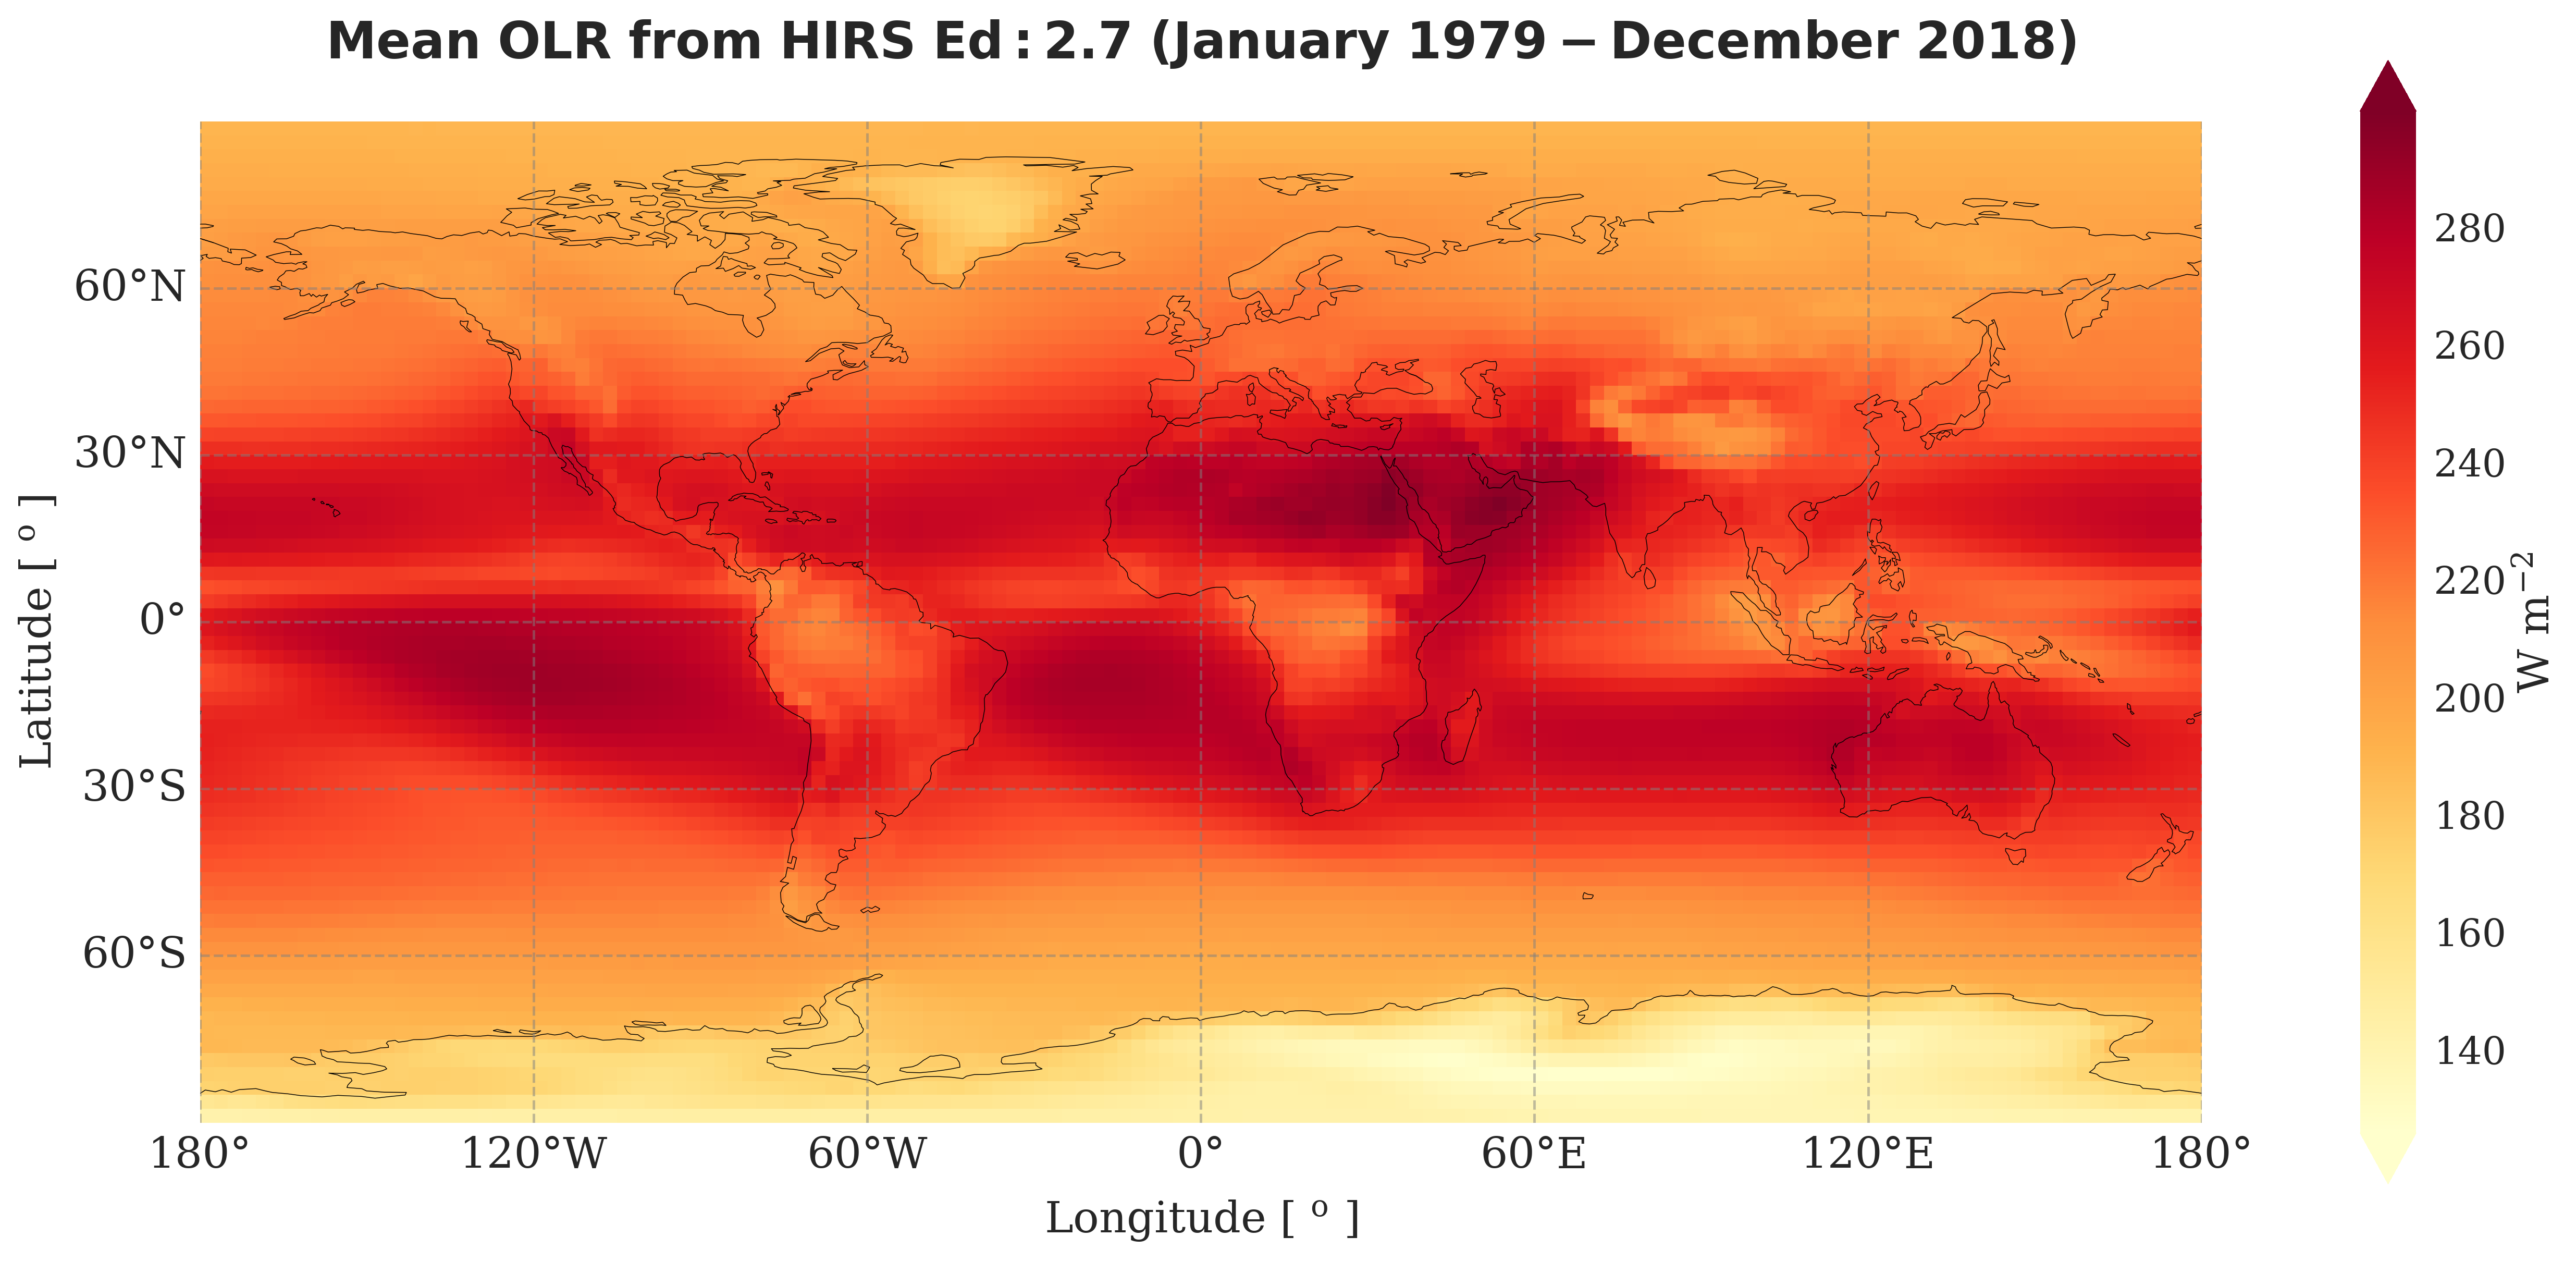

In [42]:
fig1 = plt.figure(figsize=(16, 8))
ax1 = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())

masked_average = xdf_m.to_masked_array()  # mask the data because pcolormesh cannot plot nan-values
im = plt.pcolormesh(
    xdf_m['lon'][:],
    xdf_m['lat'][:],
    masked_average,
    cmap=plt.cm.get_cmap('YlOrRd'),
    transform=ccrs.PlateCarree()
)

# Modify figure style; add lat/lon grid and labels
ax1.coastlines(color='black')
gl = ax1.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False  # hide top and right labels
gl.right_labels = False
'''
Cartopy's matplotlib gridliner takes over the xlabel and ylabel and uses it to manage
grid lines and labels.
To add labels we need to add text to the Axes, such as:'''
ax1.text(
    -0.07, 0.49, 'Latitude [ $^o$ ]', fontsize=17, va='bottom', ha='center',
    rotation='vertical', rotation_mode='anchor', transform=ax1.transAxes)
ax1.text(
    0.5, -0.12, 'Longitude [ $^o$ ]', fontsize=17, va='bottom', ha='center',
    rotation='horizontal', rotation_mode='anchor', transform=ax1.transAxes)
# Add colorbar
cb = fig1.colorbar(im, ax=ax1, label='W m$^{-2}$', fraction=0.045, pad=0.07, extend='both')
# Add title text
ax1.set_title(
    '$\\bf{Mean\ OLR\ from\ HIRS\ Ed:2.7\ (January\ 1979-December\ 2018)}$',
    fontsize=20, pad=25)

# and save the figure
fig1.savefig('./Example_1_HIRS_olr_mean.png', dpi=500, bbox_inches='tight')

**The Figure 1** shows the time-averaged Outgoing Longwave Radiation over the period January 1979 -
December 2018. The maximum values of the OLR are found in the tropics and it decreases toward the
poles. The relative minimum near the equator, in yellow colour, corresponds to the ITCZ and the
convection areas, where persistent and relatively high cloud cover reduces the LW radiation at the
TOA. Antarctica is cooler than the corresponding northern latitudes ([Harrison et al.](#harrison)).

<br>

## <a id='timeseries-global'></a> Use case 2: Global time series of the OLR

After looking at the time-averaged global distribution, in the next step, we further investigate the dataset. The OLR dataset is more than 40 years long, and another useful way of visualizing is the time series. We will calculate the global time series, plot it, and discuss the most important features.

We start by opening the combined data with Xarray `open_dataset` function 
and subselect a time range from January 1979 to December 2018.

In [12]:
filename = f'{DATADIR}olr-monthly_v02r07_197901_202207.nc'

xdf = xr.open_dataset(filename, decode_times=True, mask_and_scale=True)
xdf = xdf.sel(time=slice('1979-01-01', '2019-01-01'))

#### Apply weights and calculate the rolling mean

Next, we want to give different weights for polar and equatorial regions, and the way to do this is to use the cosine of the latitude. We then calculate the global values by using `sum` method. And we calculate the 12-month rolling mean by using the `rolling` method.

In [38]:
# calculate normalized weights
_, lat_field = np.meshgrid(xdf.lon.values, xdf.lat.values)
weight = np.cos(np.pi * lat_field / 180)
data = np.ma.masked_invalid(xdf.olr)
weight[data.mask[0, :, :]] = np.nan
weight_normalized = weight / np.nansum(weight)

# Add weights as second Xarray Data variable and apply weights to the OLR
xdf['weight_normalized'] = xr.DataArray(
    weight_normalized, coords=[xdf.lat.values, xdf.lon.values], dims=['lat', 'lon'])
xdf['olr_norma'] = xdf.olr * xdf.weight_normalized

# calculate the global values
xdf_m = xdf.olr_norma.sum(dim=['lat', 'lon'])
# calculate the 12-month rolling mean
xdf_mean_rolling = xdf_m.rolling(time=12, center=True).mean().dropna('time')

#### Plot data

Now, let's visualize the time series. Xarray offers built-in matplotlib methods to plot Data Arrays. We use the method `plot` to get the plot.<br>
We also want to add custom xticks. Our x-axis is the time, and one of the ways to work with the time variable is to use library Pandas. This library can work with both date and time. We use method `date_range` to generate the ticks with frequency of two years.

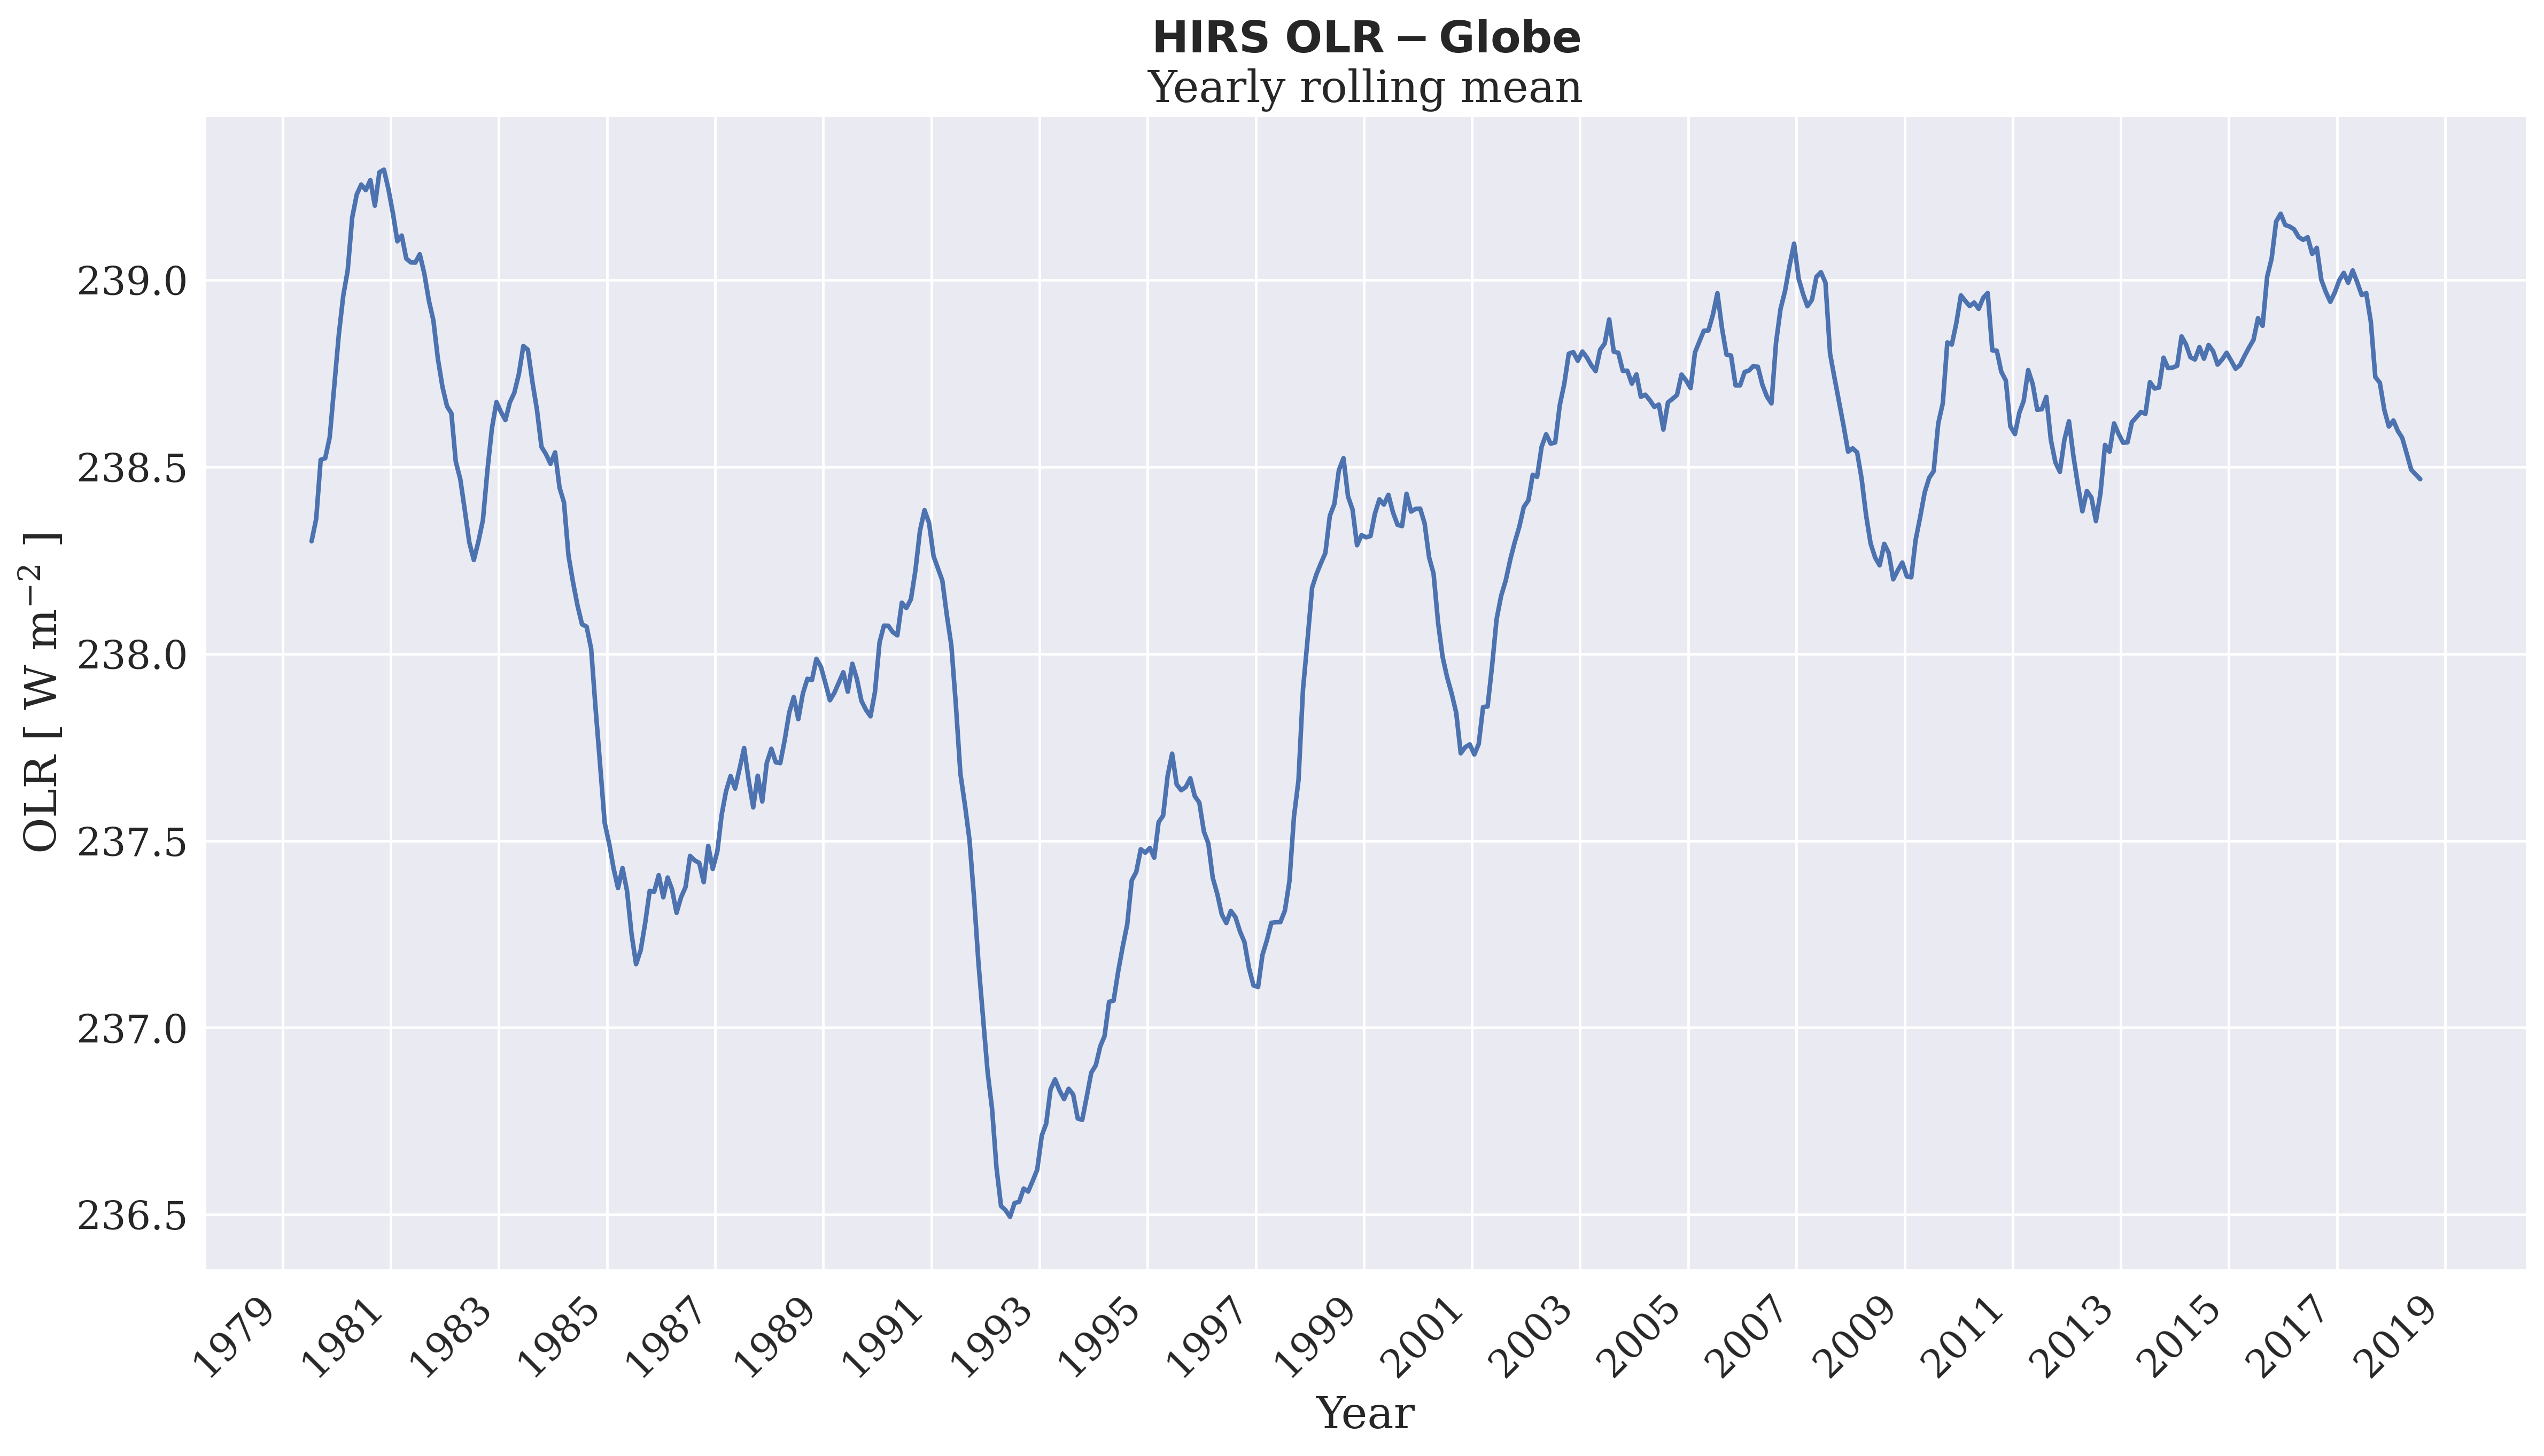

In [14]:
# Plotting.
xdf_mean_rolling.plot(figsize=[16, 8])

# Add title, x- and y-labels
plt.title('$\\bf{HIRS\ OLR-Globe }$\nYearly rolling mean')
plt.ylabel("OLR [ W m$^{-2}$ ]", fontsize=17)
plt.xlabel("Year", fontsize=17)

# Custom x-ticks
dateStart = pd.to_datetime('1979-01-01', format='%Y-%m-%d')
date_End = pd.to_datetime('2019-01-01', format='%Y-%m-%d')
dates_rng = pd.date_range(dateStart, date_End, freq='2YS')
plt.xticks(dates_rng, [dtz.strftime('%Y') for dtz in dates_rng], rotation=45)

plt.savefig('./Example_2_olr_timeserie_Globe.png', dpi=500, bbox_inches='tight')

**The Figure 2**, shows the evolution of the global mean of the OLR using a 12-month rolling mean. This long
CDR shows some interesting features such as the drop of OLR due to a global radiative perturbation
in response to volcanic eruptions, for instance, El Chichon in 1982 and Pinatubo in 1991. The main
atmospheric thermal effects of these two eruptions persist for about two years after the eruption.
The figure also shows some inter-annual variations that are suggested to be related to “El Niño” or
“La Niña” Southern Oscillation.

<br>

## <a id='timeseries-arctic'></a> Use case 3: OLR evolution in the Arctic

In the final use case, we will calculate, plot and discuss the OLR time series in the Arctic region. We can re-use code from the previous use case, but we need to add another subselection of the original dataset. <br>

We start by reading the dataset with xarray `open_dataset` method. We have used `sel` method before to select the data based on time coordinate. This time, we will select the latitude coordinate label.

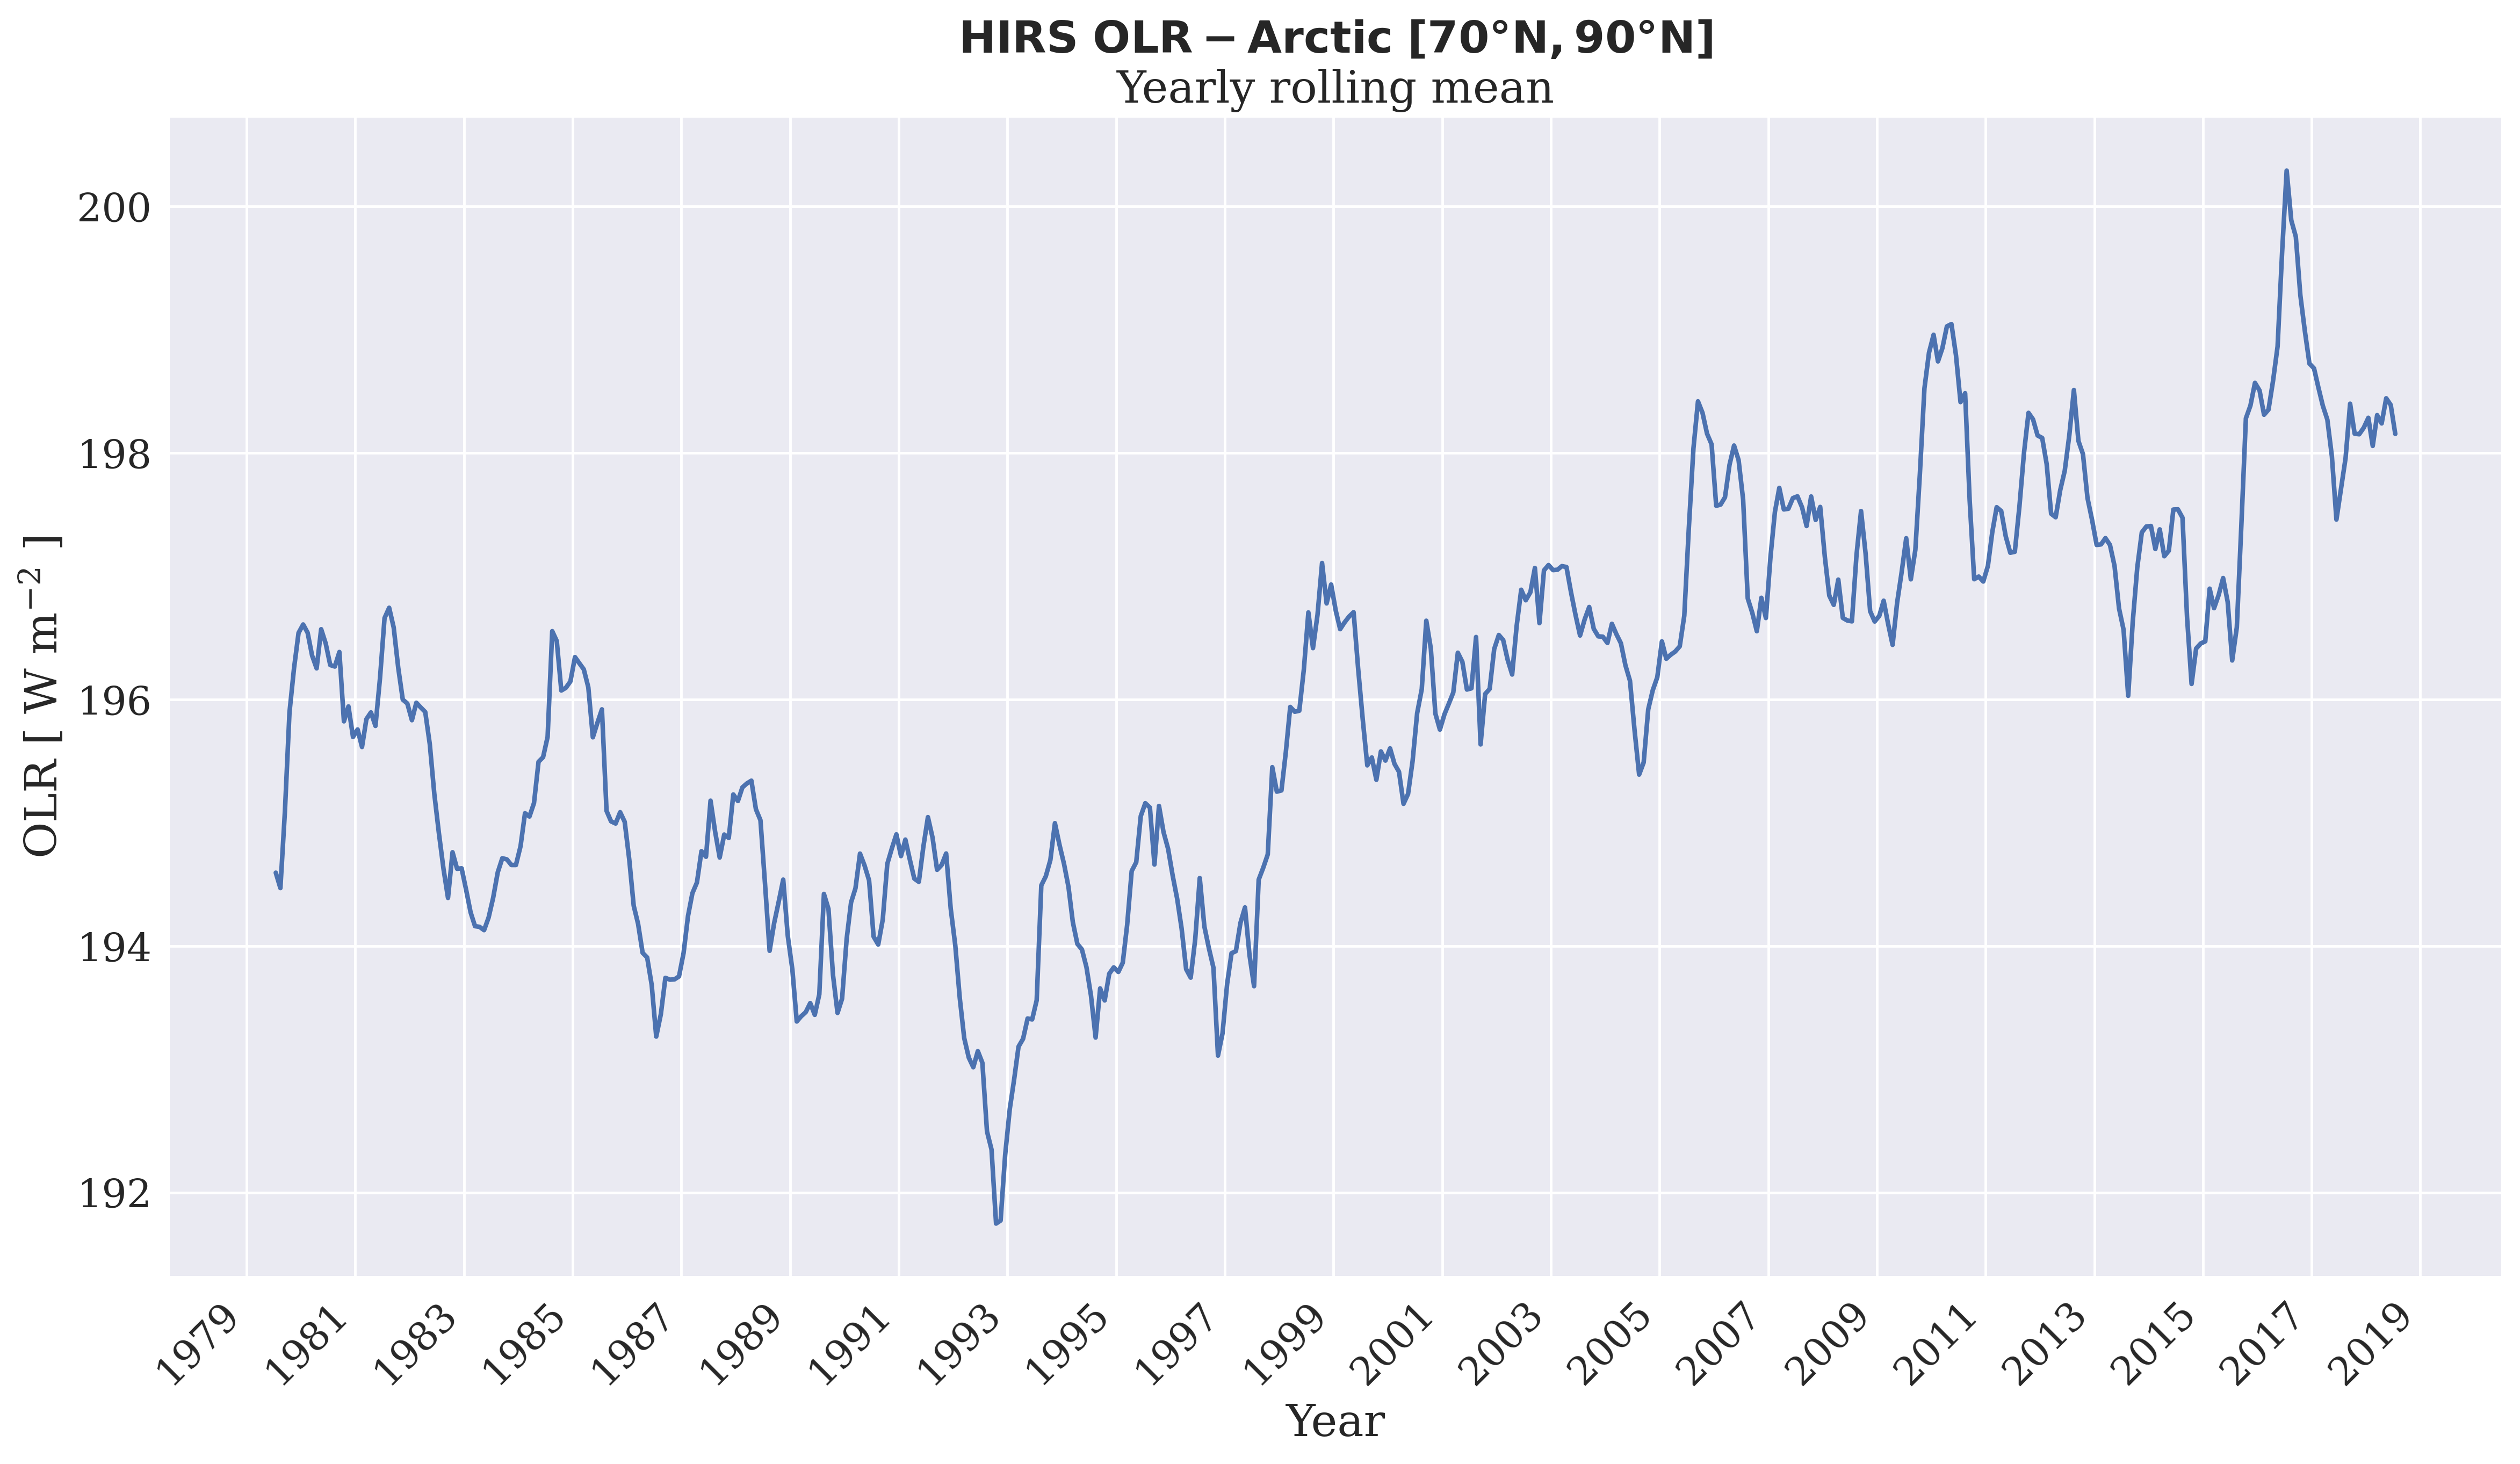

In [36]:
# Read the dataset
filename = f'{DATADIR}olr-monthly_v02r07_197901_202207.nc'
xdf = xr.open_dataset(filename, decode_times=True, mask_and_scale=True)

# Select time and latitude range
xdf = xdf.sel(time=slice('1979-01-01', '2019-01-01'))
lat_slice = slice(70, 90)
xdf = xdf.sel(lat=lat_slice)

# Calculate normalized weights
_, lat_field = np.meshgrid(xdf.lon.values, xdf.lat.values)
weight = np.cos(np.pi*lat_field/180)
data = np.ma.masked_invalid(xdf.olr)
weight[data.mask[0, :, :]] = np.nan
weight_normalized = weight / np.nansum(weight)

# Add weights as second Xarray Data variable and apply weights to the OLR
xdf['weight_normalized'] = xr.DataArray(
    weight_normalized, coords=[xdf.lat.values, xdf.lon.values], dims=['lat', 'lon'])
xdf['olr_norma'] = xdf.olr * xdf.weight_normalized

# calculate the global values
xdf_m = xdf.olr_norma.sum(dim=['lat', 'lon'])
# calculate the 12-month rolling mean
xdf_Arctic_mean_rolling = xdf_m.rolling(time=12, center=True).mean().dropna('time')

# Plotting.
xdf_Arctic_mean_rolling.plot(figsize=[16, 8])

# Add title, x- and y-labels
plt.title('$\\bf{HIRS\ OLR-Arctic\ [70°N, 90°N] }$\nYearly rolling mean')
plt.ylabel("OLR [ W m$^{-2}$ ]", fontsize=17)
plt.xlabel("Year", fontsize=17)

# Custom x ticks
dateStart = pd.to_datetime('1979-01-01', format='%Y-%m-%d')
date_End = pd.to_datetime('2019-01-01', format='%Y-%m-%d')
dates_rng = pd.date_range(dateStart, date_End, freq='2YS')
plt.xticks(dates_rng, [dtz.strftime('%Y') for dtz in dates_rng], rotation=45)

# Save figure to the disk
plt.savefig('./Example_3_olr_timeserie_Arctic.png', dpi=500, bbox_inches='tight')

**The Figure 3**, shows the evolution of the OLR in the Arctic region [70°N-90°N] for the period 1979-2019
also using a yearly rolling mean. From the image, we can infer an increase in the OLR in the Arctic
region with time. This increase is strongly marked as from 1998 and in line with the increase of
temperature in the Arctic ([Hansen et al, 2010](#hansen)), while the relative stability of the first part of the time
series is more difficult to interpret due to the major volcanic eruptions in this period.

<br>

## Get more information about Earth Radiation Budget:

- [About Earth's radiation budget from 1979 to present derived from satellite observations](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-earth-radiation-budget?tab=overview)
- [About the Climate Data Store](https://cds.climate.copernicus.eu/)
- [About the Toolbox documentation](https://cds.climate.copernicus.eu/toolbox/doc/index.html)

## <a id='references'></a> References

<a id='hansen'></a>Hansen, J., Ruedy, R., Sato, M., & Lo, K., (2010). _Global surface temperature change_. Reviews of Geophysics, 48(4).

<a id='harrison'></a>Harrison, E.F., Gurney, R. J., Foster, J. L., Gurney, R. J., & Parkinson, C. L. (1993). _Atlas of satellite observations related to global change_. Chapter: Radiation Budget at the top of the atmosphere. Cambridge University Press.

[Back to top the Page](#page-top)